## Load the Libraries

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

## Load the Datasets and Get some Insight

In [2]:
root_folder = '/Users/syukrifadzil/Desktop/Python Projects/Geological Analysis/Minerals Identification/minet'
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
                'muscovite', 'pyrite', 'quartz']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load the data and convert to tensor
dataset = ImageFolder(root_folder, transform=transforms.ToTensor())
print('Data Size: ', len(dataset))
dataset.classes

Data Size:  956


['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

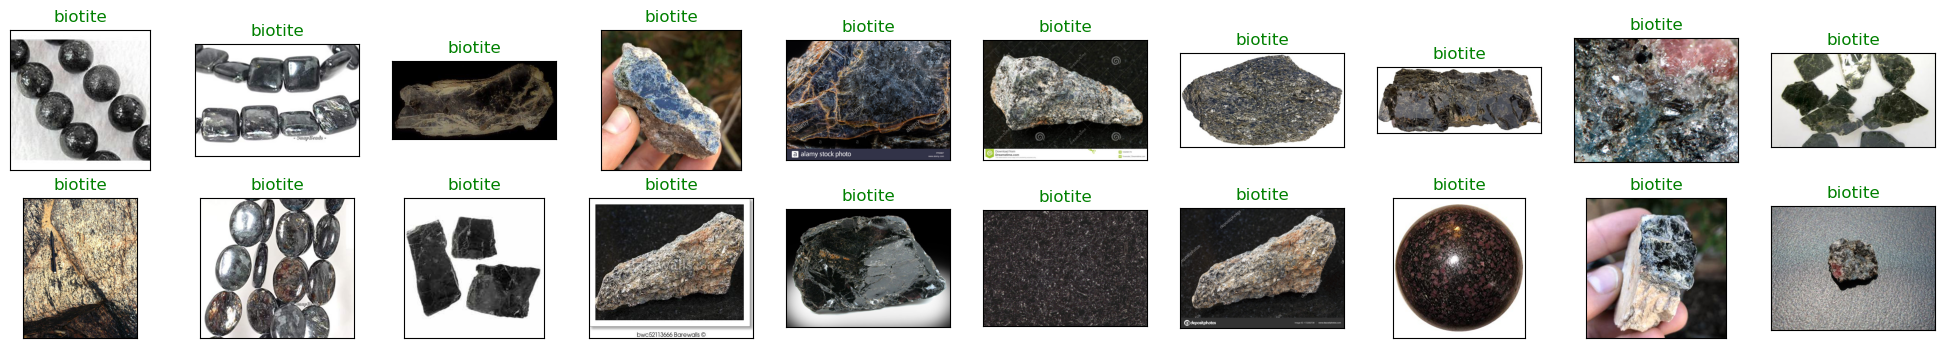

In [4]:
# Check the first 20 images of the dataset
fig = plt.figure(figsize=(25, 4))

for i in range (20):
    image, label = dataset[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [5]:
# Count the number of each of the label
count = {}

for i in range(len(dataset)):
    _, labels = dataset[i]
    label = target_label[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

# Insert count into the DataFrame
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'count']
df

Mineral  count
0      biotite     68
1      bornite    170
2  chrysocolla    163
3    malachite    235
4    muscovite     77
5       pyrite     98
6       quartz    145

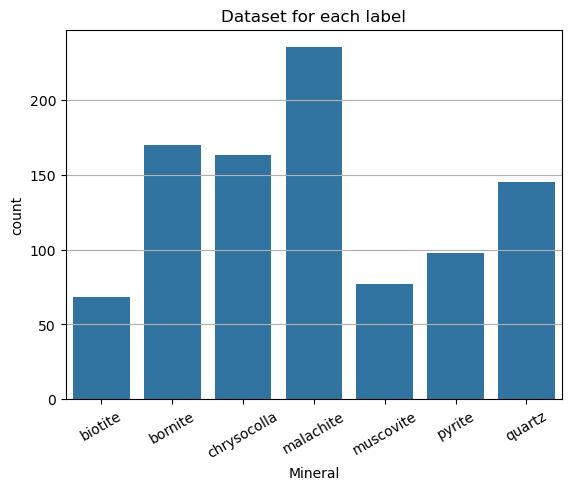

In [6]:
# Plot a barplot for easy to read
sns.barplot(x=df['Mineral'], y=df['count'])
plt.title('Dataset for each label')
plt.xticks(rotation=30)
plt.grid(axis='y')

In [7]:
# Check the image size of each dataset
height = []
weight = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    weight.append(image.size(2))

print(f"maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height)}")
print(f"maximum_weight:{np.max(weight)} \tminimum_weight:{np.min(weight)} \tmean_weight:{np.mean(weight)}")

maximum_height:6016 	minimum_height:129 	mean_height:696.7426778242677
maximum_weight:6016 	minimum_weight:144 	mean_weight:806.3995815899582


## Data Loader

### Load all the Data from the Datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.72480524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data t

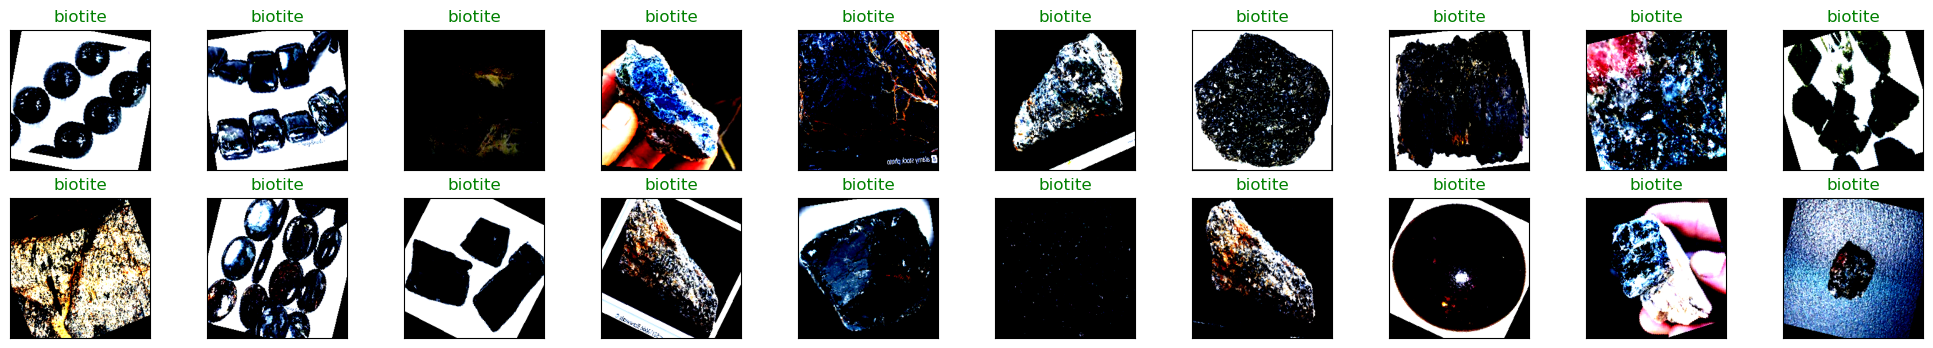

In [8]:
# Transform the format to augmentation dataset
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomRotation(30),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]) # imagenet mean and std

load_data = ImageFolder(root_folder, transform=data_transform)

# Check the image results from the transformation
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    image, label = load_data[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

### Split the Data

In [9]:
# # Ration for data split
# train_ratio = 0.90
# train_size = int(len(load_data)*train_ratio)
# val_size = int(len(load_data) - train_size)
# test_size = len(load_data) - (train_size + val_size)

# datasize = len(load_data)
# data_idx = [x for x in range(datasize)]

# np.random.seed(97)
# np.random.shuffle(data_idx)

# train_idx = data_idx[:train_size]
# val_idx = data_idx[train_size:-test_size]
# test_idx = data_idx[train_size+val_size:]

# # Split the data into 3 sets
# train_set, val_set, test_set = random_split(load_data, [train_size, val_size, test_size])

# print('size of training data: ', len(train_idx))
# print('size of validation data: ', len(val_idx))
# print('size of test data: ', len(test_idx))

In [10]:
def plot_dist(indexes, dataset=dataset):
    dist = {}
    count = Counter()
    for i in indexes:
        _, label = dataset[i]
        count[target_label[label]] += 1
    
    dist_2 = dict(sorted(count.items(), key=lambda kv: kv[1], reverse=True))
    plt.bar(dist_2.keys(), dist_2.values())
    plt.xticks(rotation=30)
    plt.title('Data distribution'); plt.ylabel('count')
    plt.show()

In [11]:
# Split the data to get same distribution
# Get the index and the label
idx_label = {}
for i in range(len(dataset)):
    _, label = dataset[i]
    idx_label[i] = label
    
# Split data for validation
x_train, x_val, y_train, y_val = train_test_split(list(idx_label.keys()), list(idx_label.values()), 
                                                  stratify=list(idx_label.values()), test_size=0.05)

In [12]:
# Exclude the validation index from the dataset
x_val
idx_label_2 = {}
for idx, label in idx_label.items():
    if idx not in x_val:
        idx_label_2[idx] = label
        
# Split data train and test after excluding x_val
x_train, x_test, y_train, y_test = train_test_split(list(idx_label_2.keys()), list(idx_label_2.values()), stratify=list(idx_label_2.values()),
                                                    test_size=0.05)

print(len(x_train))
print(len(x_val))
print(len(x_test))

862
48
46


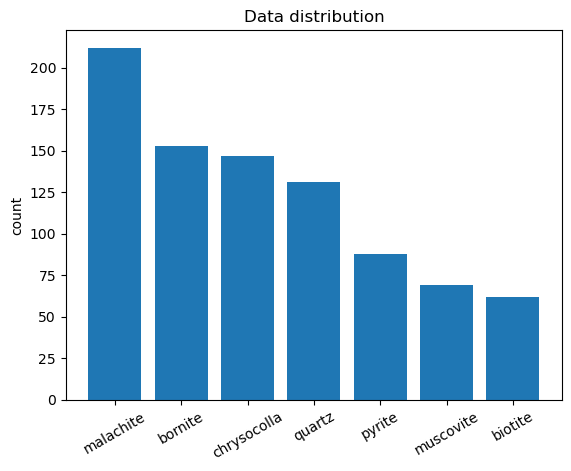

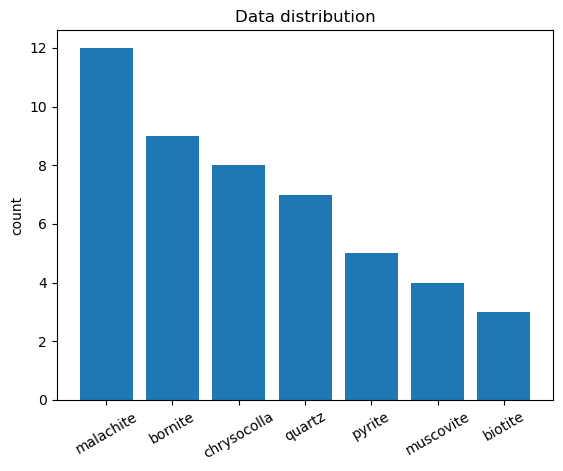

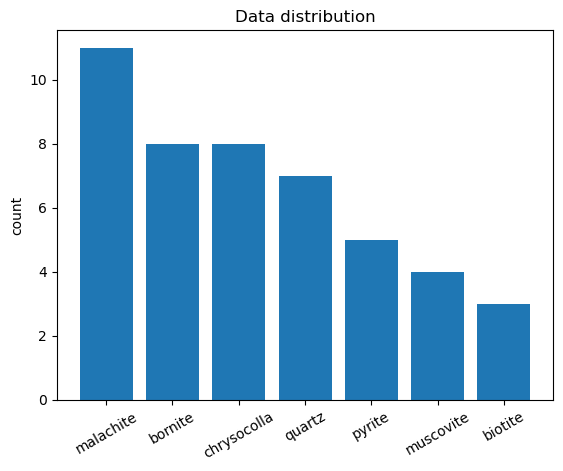

In [13]:
plot_dist(x_train)
plot_dist(x_val)
plot_dist(x_test)

In [14]:
# Load into dataloader for each of the split data
batch_size = 128

# Using subset to get data from indexes with the same distribution label
train_set = SubsetRandomSampler(x_train)
val_set = SubsetRandomSampler(x_val)
test_set = SubsetRandomSampler(x_test)

# Dataloader
train_loader = DataLoader(load_data, batch_size=batch_size,
                          shuffle=False, num_workers=4, sampler=train_set)
val_loader = DataLoader(load_data, batch_size=batch_size,
                        num_workers=4, sampler=val_set)
test_loader = DataLoader(load_data, batch_size=batch_size,
                         num_workers=4, sampler=test_set)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


images.shape: torch.Size([128, 3, 224, 224])


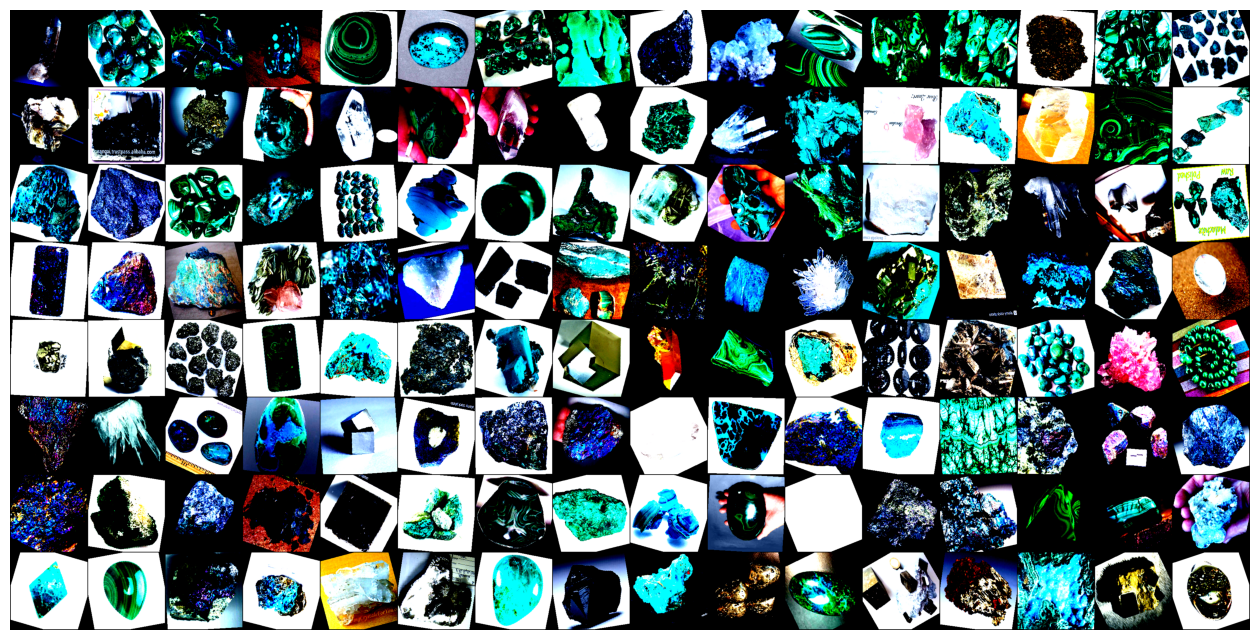

In [15]:
# Check the images in the trainloader for one batch
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

## Build the Model

In [16]:
# Calculation for covnet
w1 = 20
F_SIZE = 3
F_POOL = 3
P = 0 
S_SIZE = 1
S_POOL = 3

SIZE = (w1 - F_SIZE + 2*P)/S_SIZE + 1 # Size after conv
POOL = (SIZE - F_POOL)/S_POOL + 1
w1 = POOL # Size after pool
print(SIZE)
w1

18.0


6.0

In [17]:
6*6*64

2304

### My own Model

In [18]:
class Mineral_1(nn.Module):
    def __init__ (self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 48, 11, stride=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 70x70
            
            nn.Conv2d(48, 128, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 64x64
            
            nn.Conv2d(128, 128, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(4, 3), #out 20X20
            
            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 3), #out 20X20
            
            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
            nn.LogSoftmax(dim=1),
            )
    
    def forward(self, x):
        out = self.net(x)
        return out
    
model_1 = Mineral_1()
model_1.to(device)
model_1

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

In [19]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            image = image.to(device); label = label.to(device);

            output = model(image)
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += torch.mean(correct.type(torch.FloatTensor))

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)
                    loss = criterion(output, label)
                    
                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(correct.type(torch.FloatTensor))

                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_accu.append(train_acc/len(train_loader))
            val_accu.append(accuracy/len(val_loader))
            model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                  "Test Accuracy: {:.3f}.. ".format(accuracy/len(val_loader)),
                  "Time: {:.2f}s" .format((time.time()-since)))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_accuracy': train_accu, 'val_accuracy':val_accu}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
# Saving the model created
def save_model(model, optimizer, fpath):
    checkpoint = {'model' : model,
                  'state_dict' : model.state_dict(),
                  'optim' : optimizer.state_dict()
    }
    
    torch.save(checkpoint, fpath)
    
# Load the model
def load_model(fpath, inferece = True):
    check = torch.load(fpath, weights_only=False)
    model = check['model']
    model.load_state_dict(check['state_dict'])
    if inferece:
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
    else:
        model.train()
    return model

In [21]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
epoch = 40
history_mineral = fit(epoch, model_1, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.887..  Test Loss: 1.778..  Train Accuracy: 0.278..  Test Accuracy: 0.250..  Time: 91.38s
Epoch: 2/40..  Train Loss: 1.747..  Test Loss: 1.586..  Train Accuracy: 0.325..  Test Accuracy: 0.396..  Time: 89.03s
Epoch: 3/40..  Train Loss: 1.531..  Test Loss: 1.360..  Train Accuracy: 0.421..  Test Accuracy: 0.458..  Time: 91.31s
Epoch: 4/40..  Train Loss: 1.275..  Test Loss: 1.119..  Train Accuracy: 0.506..  Test Accuracy: 0.583..  Time: 89.67s
Epoch: 5/40..  Train Loss: 1.121..  Test Loss: 0.944..  Train Accuracy: 0.566..  Test Accuracy: 0.625..  Time: 89.25s
Epoch: 6/40..  Train Loss: 0.990..  Test Loss: 0.830..  Train Accuracy: 0.629..  Test Accuracy: 0.667..  Time: 91.55s
Epoch: 7/40..  Train Loss: 0.913..  Test Loss: 0.766..  Train Accuracy: 0.663..  Test Accuracy: 0.708..  Time: 91.21s
Epoch: 8/40..  Train Loss: 0.863..  Test Loss: 0.726..  Train Accuracy: 0.685..  Test Accuracy: 0.729..  Time: 91.37s
Epoch: 9/40..  Train Loss: 0.814..  Test Loss: 0.713..  

In [22]:
# Save the model
save_model(model_1, optimizer, 'mineral_seq_own.pt')

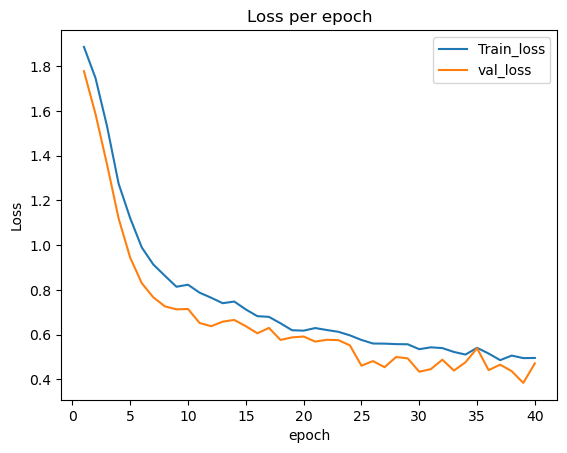

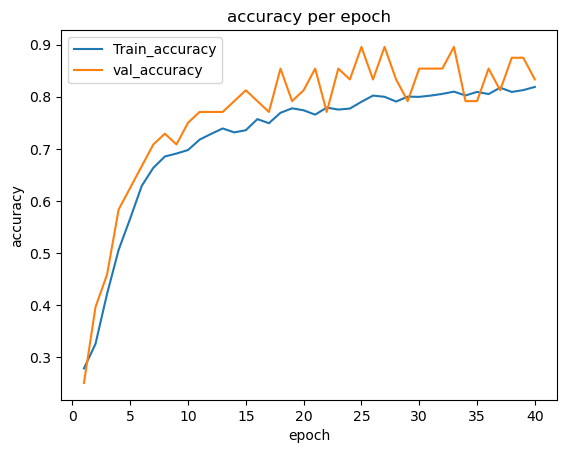

In [23]:
def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='val_loss')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
def plot_accuracy(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_accuracy'], label='Train_accuracy')
    plt.plot(epoch, history['val_accuracy'], label='val_accuracy')
    plt.title('accuracy per epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
plot_loss(history_mineral, epoch)
plot_accuracy(history_mineral, epoch)

### Pre-trained model

In [24]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelVGG = models.vgg16(pretrained=True)

# Freeze the parameters so it doesn't backdrop through
for param in modelVGG.parameters():
    param.requires_grad = False

# vgg16
modelVGG.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(in_features=4096, out_features=1000),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(in_features=1000, out_features=500),
                                    nn.Linear(500, 7),
                                    nn.LogSoftmax(dim=1)
                                    )

modelVGG.to(device)
modelVGG.train()
modelVGG

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(modelVGG.classifier.parameters(), lr=0.0001)
epoch = 40
history_VGG = fit(epoch, modelVGG, train_loader, val_loader, criterion, optimizer)

Epoch: 1/40..  Train Loss: 1.760..  Test Loss: 1.473..  Train Accuracy: 0.290..  Test Accuracy: 0.604..  Time: 142.14s
Epoch: 2/40..  Train Loss: 1.323..  Test Loss: 0.986..  Train Accuracy: 0.543..  Test Accuracy: 0.625..  Time: 142.37s
Epoch: 3/40..  Train Loss: 0.944..  Test Loss: 0.856..  Train Accuracy: 0.667..  Test Accuracy: 0.646..  Time: 142.35s
Epoch: 4/40..  Train Loss: 0.678..  Test Loss: 0.645..  Train Accuracy: 0.756..  Test Accuracy: 0.812..  Time: 145.20s
Epoch: 5/40..  Train Loss: 0.616..  Test Loss: 0.518..  Train Accuracy: 0.789..  Test Accuracy: 0.792..  Time: 142.09s
Epoch: 6/40..  Train Loss: 0.523..  Test Loss: 0.587..  Train Accuracy: 0.831..  Test Accuracy: 0.833..  Time: 144.27s
Epoch: 7/40..  Train Loss: 0.463..  Test Loss: 0.556..  Train Accuracy: 0.828..  Test Accuracy: 0.750..  Time: 142.69s
Epoch: 8/40..  Train Loss: 0.396..  Test Loss: 0.474..  Train Accuracy: 0.858..  Test Accuracy: 0.812..  Time: 141.21s
Epoch: 9/40..  Train Loss: 0.348..  Test Loss: 0

In [26]:
# Save the model
save_model(modelVGG, optimizer, 'mineral_vgg.pt')

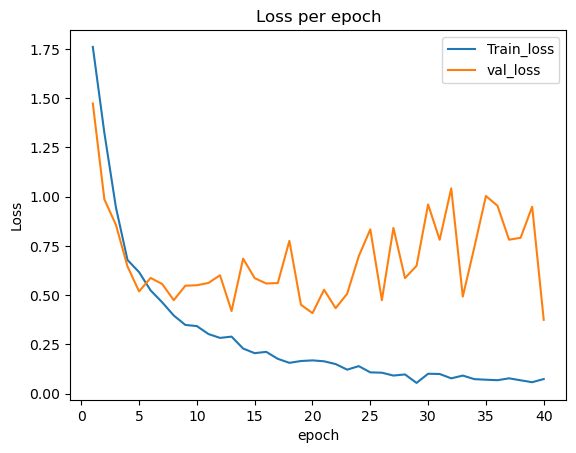

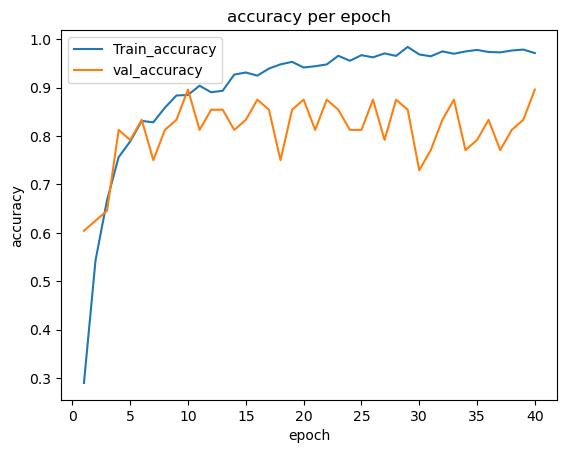

In [27]:
plot_loss(history_VGG, epoch)
plot_accuracy(history_VGG, epoch)

## Prediction and Evaluation

In [28]:
def predict_label(model, dataloader):
    prediction_list = []
    labels = []
    model.to(device)
    model.eval()
    for i, batch in enumerate(dataloader):
        image, label = batch
        image = image.to(device); label = label.to(device)
      
        out = model(image)
        ps = torch.exp(out)
        _, top_class = torch.max(ps , 1)
        preds = np.squeeze(top_class.cpu().numpy())
        prediction_list.append(preds)
        labels.append(label.cpu().numpy())
    return np.squeeze(prediction_list), np.squeeze(labels)

In [39]:
def predict_plot(test_loader, model, target_label=target_label, n=20):

    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images.numpy()

    # move model inputs to cuda, if GPU available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        images = images.cuda()

    model.eval()
    # get sample outputs
    model.to(device)
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy()) #np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    images = images.cpu()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(n):
        ax = fig.add_subplot(2, n // 2, idx + 1, xticks=[], yticks=[])
        plt.imshow(images[idx].permute(1 ,2, 0))
        ax.set_title("{} ({})".format(target_label[preds[idx]], target_label[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.show()

### My Model

In [30]:
model_mineral = load_model('mineral_seq_own.pt', inferece=True)
model_mineral

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax(dim=1)
  )
)

In [31]:
# How the model perform in test_data
y_predict, y_true = predict_label(model_mineral, test_loader)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.53      1.00      0.70         8
           2       1.00      1.00      1.00         8
           3       1.00      0.91      0.95        11
           4       0.00      0.00      0.00         4
           5       0.60      0.60      0.60         5
           6       0.83      0.71      0.77         7

    accuracy                           0.74        46
   macro avg       0.57      0.60      0.57        46
weighted avg       0.70      0.74      0.70        46



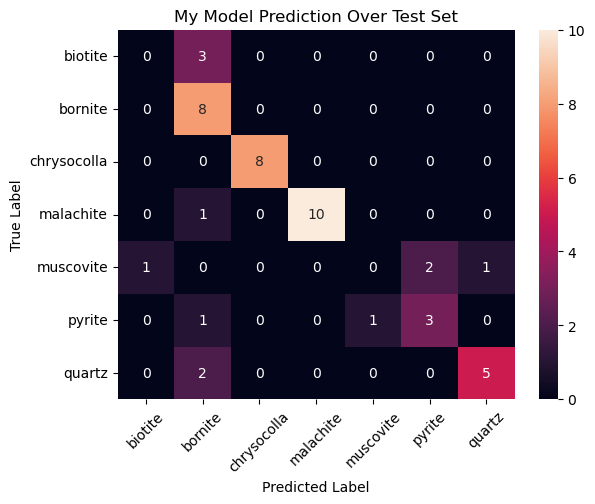

In [32]:
# Plot the confusion matric
print(classification_report(y_true, y_predict))

sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label,
           rotation=0)
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label,
           rotation=45)
plt.title('My Model Prediction Over Test Set')
plt.show()

### VGG Model

In [33]:
model_vgg = load_model('mineral_vgg.pt', inferece=True)

In [34]:
# How the model perform in test_data
y_predict_vgg, y_true_vgg = predict_label(model_vgg, test_loader)

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.86      0.75      0.80         8
           2       0.71      0.62      0.67         8
           3       0.75      0.82      0.78        11
           4       1.00      0.50      0.67         4
           5       0.60      0.60      0.60         5
           6       0.78      1.00      0.88         7

    accuracy                           0.74        46
   macro avg       0.74      0.71      0.71        46
weighted avg       0.76      0.74      0.74        46



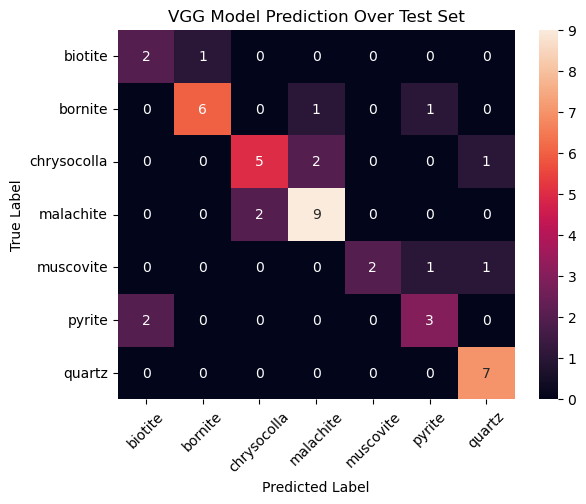

In [35]:
# Plot the confusion matrix
print(classification_report(y_true_vgg, y_predict_vgg))

sns.heatmap(confusion_matrix(y_true_vgg, y_predict_vgg), annot=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label,
           rotation=0)
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label,
           rotation=45)
plt.title('VGG Model Prediction Over Test Set')
plt.show()

### Plot Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input da

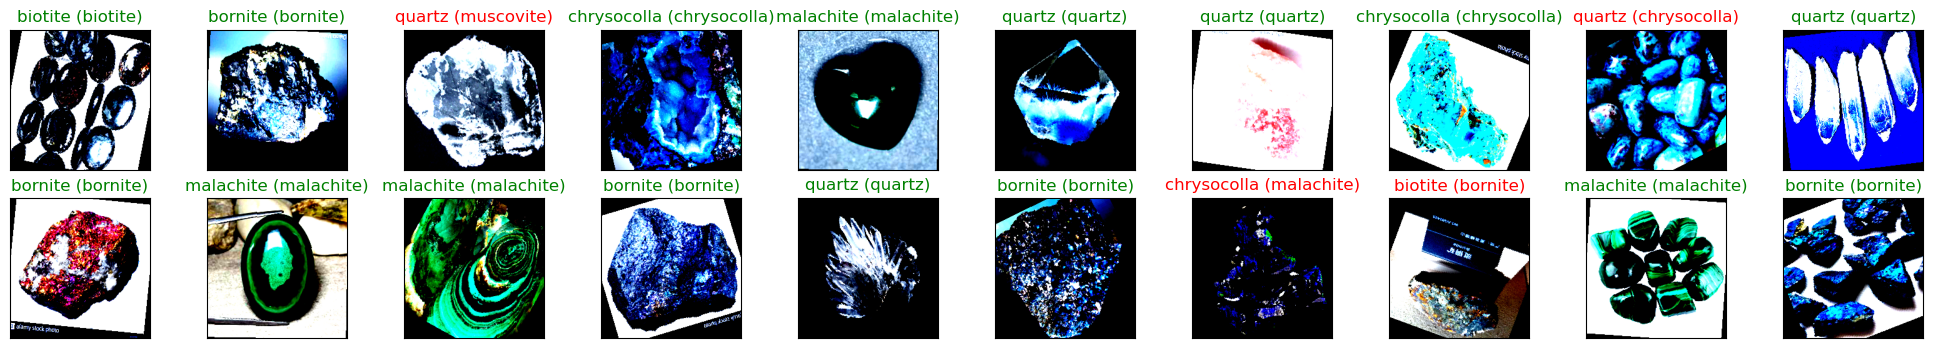

In [40]:
predict_plot(test_loader, model_vgg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input dat

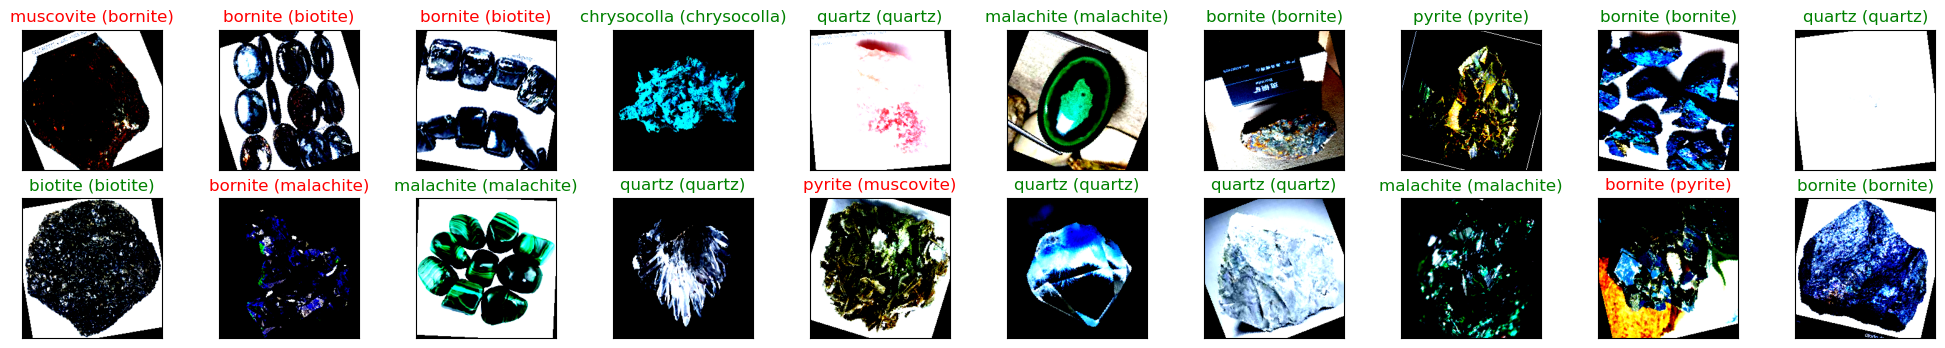

In [41]:
predict_plot(test_loader, model_mineral)